# Mobility data anlaysis (Matt)

In [1]:
# imports and setup
from   ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   scipy.stats import permutation_test
import seaborn as sns
from   sklearn.preprocessing import LabelBinarizer
import string
import warnings

data_dir = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')
metadata_dir = os.path.join(data_dir, 'metadata')

# settings
conlit_file = 'CONLIT_CharData_AP_6.csv.gz'
early_file = 'EARLY_CharData_MW.csv.gz'
do_early_calcs = True # do early calculations? Else use AP's data

## Load data

### Mobility

In [2]:
def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

def index_int_string(idx):
    '''Make Chicago index labels consistent'''
    try:
        int(idx)
        return(str(idx).rjust(8, '0'))
    except ValueError:
        return(idx)

conlit = pd.read_csv(
    os.path.join(derived_dir, conlit_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
conlit['source'] = 'conlit'

early = pd.read_csv(
    os.path.join(derived_dir, early_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
early.index = early.index.to_series().apply(index_int_string)

# set source corpus for EARLY data
def source_mapper(label):
    if label.startswith('eaf'):
        return('eaf')
    elif label.startswith('Wright'):
        return('wright')
    else:
        return('chicago')

early['source'] = early.index.to_series().apply(source_mapper)

### Temporary calculations for EARLY

Will work with Andrew's data when available. Calculating a few for immediate use. Set `do_early_calcs=False` at top to ignore.

In [3]:
if do_early_calcs:
    early['avg_Distance_GPE_Tokens'] = early.dist_miles.divide(early.Tokens)
    early['gpe_places_total'] = early.gpe_places.apply(len)
    early['avg_Distance_GPE'] = early.dist_miles.divide(early.gpe_places_total).fillna(0)

### Metadata

In [4]:
# EAF and Wright
eaf = pd.read_csv(
    os.path.join(data_dir, 'metadata', 'eaf-wright-metadata.tsv'), 
    sep='\t', 
    index_col='source_id'
)
eaf.index.rename('book_id', inplace=True)
eaf.rename(columns={'gender':'author_gender'}, inplace=True)

# Chicago
chi = pd.read_csv(
    os.path.join(metadata_dir, 'chicago-books.csv'),
    index_col='BOOK_ID'
)
chi.index.rename('book_id', inplace=True)
chi.index = chi.index.to_series().apply(index_int_string)
chi.columns = [i.lower() for i in chi.columns]

chi_auth = pd.read_csv(
    os.path.join(metadata_dir, 'chicago-authors.csv'),
)
chi_auth.columns = [i.lower() for i in chi_auth.columns]

chi_idx = chi.index
chi = chi.merge(chi_auth[['auth_id', 'gender']], how='left', on='auth_id').set_index(chi_idx)
chi.rename(columns={'gender':'author_gender', 'publ_date':'pub_date'}, inplace=True)
chi['author'] = chi[['auth_last', 'auth_first']].agg(', '.join, axis=1)

# CONLIT
con = pd.read_csv(
    os.path.join(metadata_dir, 'CONLIT_META.csv'),
    index_col='ID'
)
con.index.rename('book_id', inplace=True)
con.index = con.index.to_series().apply(lambda x: x[:-4]) #delete '.txt'
# fix up indexing errors
con.rename(
    index={
        '2009_LaFleur,Suzanne_Love,Aubrey_MGtxt':'2009_LaFleur,Suzanne_Love,Aubrey_M', 
        '2015_Jackson,AL_ComeToMeRecklessly_ROM.txt':'2015_Jackson,AL_ComeToMeRecklessly_ROM'
    }, \
    inplace=True
)
con.columns = [i.lower() for i in con.columns]
con.rename(columns={'pubdate':'pub_date', 'work_title':'title'}, inplace=True)
con['author'] = con[['author_last', 'author_first']].fillna('').astype(str).agg(', '.join, axis=1)

# integrate target columns
cols = ['author', 'title', 'pub_date', 'author_gender']
meta = pd.concat([eaf[cols], chi[cols], con[cols]], axis=0)

### Integrate

In [5]:
conlit = conlit.join(meta[['pub_date', 'author_gender']])
early = early.join(meta[['pub_date', 'author_gender']])

# set canonical values where needed
early['Category'] = 'FIC'
early.loc[(early.source=='chicago') & (early.pub_date<=1945), ['source']] = 'chicago_1'
early.loc[(early.source=='chicago') & (early.pub_date>1945), ['source']] = 'chicago_2'

## Feature differences by facet 

### CONLIT

In [6]:
def significance_label(pvalue, levels=[0.05, 0.01, 0.001]):
    if pvalue < levels[2]:
        return '***'
    elif pvalue < levels[1]:
        return '**'
    elif pvalue < levels[0]:
        return '*'
    else: 
        return ''

def diff_means(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def compare_facets(df, facets, cols_to_drop, statistic=diff_means):
    '''Compare statistic in numeric cols of df via permutation. Display results, return nothing.'''
    cols = df.select_dtypes(include='number').drop(columns=cols_to_drop).columns
    for facet in facets:
        print(f"\n==============\nFacet: {facet}\n==============")
        df = df.dropna(subset=[facet])
        for level in df[facet].unique():
            data = (df.loc[df[facet]==level, cols], df.loc[~(df[facet]==level), cols])
            level_mean = np.mean(data[0], axis=0)
            other_mean = np.mean(data[1], axis=0)
            output = pd.DataFrame(level_mean, columns=[level]).join(pd.DataFrame(other_mean, columns=['others']))
            res = permutation_test(data, statistic)
            output['diff'] = res.statistic
            output['p'] = res.pvalue
            output['sig'] = output['p'].apply(significance_label)
            display(output)

In [7]:
facet_by = ['inf_gender', 'Category', 'Genre', 'author_gender']
ignore_numeric_cols = ['char_id', 'char_rank', 'num_words']
compare_facets(conlit, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


,she/her,others,diff,p,sig
Unnamed: 0,1.462906e+03,1.337531e+03,125.374687,0.0002,***
char_count,3.752280e+03,3.844495e+03,-92.215652,0.4040,
num_gpe_places,1.635618e+01,2.181495e+01,-5.458775,0.0002,***
num_nongpe_places,1.227573e+02,1.232856e+02,-0.528334,0.8730,
num_all_places,1.386202e+02,1.445245e+02,-5.904251,0.0986,
dist_miles,5.150145e+04,7.275667e+04,-21255.222639,0.0002,***
Tokens,1.195170e+05,1.319007e+05,-12383.666379,0.0002,***
num_gpe_places_norm,1.410452e-04,1.701072e-04,-0.000029,0.0002,***
num_nongpe_places_norm,1.126911e-03,1.047563e-03,0.000079,0.0010,**
num_gpe_places_norm_byCharacter,5.223790e-03,9.569243e-03,-0.004345,0.0002,***


,he/him/his,others,diff,p,sig
Unnamed: 0,1.368892e+03,1.393914e+03,-25.022559,0.4434,
char_count,4.012727e+03,3.475705e+03,537.021673,0.0002,***
num_gpe_places,2.202536e+01,1.666371e+01,5.361652,0.0002,***
num_nongpe_places,1.273429e+02,1.158797e+02,11.463255,0.0006,***
num_all_places,1.487856e+02,1.320513e+02,16.734309,0.0002,***
dist_miles,7.353378e+04,5.277104e+04,20762.743069,0.0002,***
Tokens,1.334723e+05,1.183421e+05,15130.192782,0.0002,***
num_gpe_places_norm,1.691580e-04,1.462232e-04,0.000023,0.0004,***
num_nongpe_places_norm,1.072778e-03,1.074063e-03,-0.000001,0.9684,
num_gpe_places_norm_byCharacter,8.396291e-03,7.762161e-03,0.000634,0.1702,


,they/them/their,others,diff,p,sig
Unnamed: 0,8.987339e+02,1.400767e+03,-502.032986,0.0002,***
char_count,1.490613e+03,3.924423e+03,-2433.809954,0.0002,***
num_gpe_places,1.887097e+01,2.010324e+01,-1.232270,0.5532,
num_nongpe_places,6.651613e+01,1.257882e+02,-59.272061,0.0002,***
num_all_places,8.490323e+01,1.453390e+02,-60.435822,0.0002,***
dist_miles,6.188341e+04,6.606377e+04,-4180.362043,0.6984,
Tokens,1.099098e+05,1.287408e+05,-18831.019963,0.0002,***
num_gpe_places_norm,1.833875e-04,1.596264e-04,0.000024,0.0724,
num_nongpe_places_norm,6.947576e-04,1.091131e-03,-0.000396,0.0002,***
num_gpe_places_norm_byCharacter,2.598111e-02,7.320662e-03,0.018660,0.0002,***



Facet: Category


,FIC,others,diff,p,sig
Unnamed: 0,1.359055e+03,1.423131e+03,-64.075913,0.0490,*
char_count,4.206708e+03,2.889110e+03,1317.598417,0.0002,***
num_gpe_places,1.334801e+01,3.586308e+01,-22.515074,0.0002,***
num_nongpe_places,1.239819e+02,1.210672e+02,2.914638,0.3420,
num_all_places,1.369151e+02,1.560636e+02,-19.148500,0.0002,***
dist_miles,3.803604e+04,1.315933e+05,-93557.294267,0.0002,***
Tokens,1.216897e+05,1.425312e+05,-20841.473990,0.0002,***
num_gpe_places_norm,1.172322e-04,2.633057e-04,-0.000146,0.0002,***
num_nongpe_places_norm,1.116034e-03,9.722597e-04,0.000144,0.0002,***
num_gpe_places_norm_byCharacter,3.801441e-03,1.845698e-02,-0.014656,0.0002,***


,NON,others,diff,p,sig
Unnamed: 0,1.423131e+03,1.359055e+03,64.075913,0.0492,*
char_count,2.889110e+03,4.206708e+03,-1317.598417,0.0002,***
num_gpe_places,3.586308e+01,1.334801e+01,22.515074,0.0002,***
num_nongpe_places,1.210672e+02,1.239819e+02,-2.914638,0.3458,
num_all_places,1.560636e+02,1.369151e+02,19.148500,0.0002,***
dist_miles,1.315933e+05,3.803604e+04,93557.294267,0.0002,***
Tokens,1.425312e+05,1.216897e+05,20841.473990,0.0002,***
num_gpe_places_norm,2.633057e-04,1.172322e-04,0.000146,0.0002,***
num_nongpe_places_norm,9.722597e-04,1.116034e-03,-0.000144,0.0002,***
num_gpe_places_norm_byCharacter,1.845698e-02,3.801441e-03,0.014656,0.0002,***



Facet: Genre


,YA,others,diff,p,sig
Unnamed: 0,2.376198e+03,1.309436e+03,1066.761893,0.0002,***
char_count,5.664130e+03,3.687362e+03,1976.767968,0.0002,***
num_gpe_places,1.151977e+01,2.063453e+01,-9.114752,0.0002,***
num_nongpe_places,1.308249e+02,1.225840e+02,8.240877,0.1484,
num_all_places,1.419040e+02,1.426617e+02,-0.757787,0.9298,
dist_miles,2.873762e+04,6.843094e+04,-39693.325749,0.0002,***
Tokens,1.060571e+05,1.293940e+05,-23336.921317,0.0002,***
num_gpe_places_norm,1.134307e-04,1.639511e-04,-0.000051,0.0002,***
num_nongpe_places_norm,1.257066e-03,1.060602e-03,0.000196,0.0004,***
num_gpe_places_norm_byCharacter,2.359346e-03,8.561739e-03,-0.006202,0.0002,***


,SF,others,diff,p,sig
Unnamed: 0,1.049036e+03,1.407032e+03,-357.996018,0.0002,***
char_count,3.852243e+03,3.811337e+03,40.906480,0.8110,
num_gpe_places,1.274775e+01,2.068896e+01,-7.941211,0.0002,***
num_nongpe_places,1.167117e+02,1.236771e+02,-6.965376,0.1792,
num_all_places,1.288423e+02,1.438227e+02,-14.980372,0.0106,*
dist_miles,3.113784e+04,6.892692e+04,-37789.088730,0.0002,***
Tokens,1.443770e+05,1.264431e+05,17933.837820,0.0002,***
num_gpe_places_norm,9.787891e-05,1.662170e-04,-0.000068,0.0002,***
num_nongpe_places_norm,9.019052e-04,1.088305e-03,-0.000186,0.0002,***
num_gpe_places_norm_byCharacter,3.721130e-03,8.552555e-03,-0.004831,0.0002,***


,BS,others,diff,p,sig
Unnamed: 0,8.637631e+02,1.429352e+03,-565.588548,0.0002,***
char_count,4.729731e+03,3.723497e+03,1006.233724,0.0002,***
num_gpe_places,1.769478e+01,2.028200e+01,-2.587221,0.0676,
num_nongpe_places,1.434257e+02,1.210916e+02,22.334103,0.0002,***
num_all_places,1.606185e+02,1.408196e+02,19.798874,0.0006,***
dist_miles,4.963276e+04,6.749295e+04,-17860.197244,0.0056,**
Tokens,1.551191e+05,1.251795e+05,29939.630562,0.0002,***
num_gpe_places_norm,1.264255e-04,1.641118e-04,-0.000038,0.0002,***
num_nongpe_places_norm,1.016651e-03,1.078890e-03,-0.000062,0.1168,
num_gpe_places_norm_byCharacter,4.616684e-03,8.515537e-03,-0.003899,0.0002,***


,NYT,others,diff,p,sig
Unnamed: 0,1.717746e+03,1.317219e+03,400.527192,0.0002,***
char_count,3.719703e+03,3.831665e+03,-111.961172,0.4286,
num_gpe_places,1.635167e+01,2.071042e+01,-4.358750,0.0002,***
num_nongpe_places,1.296244e+02,1.219472e+02,7.677169,0.0496,*
num_all_places,1.455813e+02,1.420807e+02,3.500688,0.4616,
dist_miles,5.210440e+04,6.834462e+04,-16240.212717,0.0034,**
Tokens,1.182688e+05,1.296169e+05,-11348.150466,0.0010,**
num_gpe_places_norm,1.499980e-04,1.626170e-04,-0.000013,0.1004,
num_nongpe_places_norm,1.193802e-03,1.051635e-03,0.000142,0.0002,***
num_gpe_places_norm_byCharacter,4.899327e-03,8.747524e-03,-0.003848,0.0002,***


,MY,others,diff,p,sig
Unnamed: 0,1.372474e+03,1.378647e+03,-6.172560,0.9114,
char_count,4.099150e+03,3.788169e+03,310.980587,0.0952,
num_gpe_places,1.328632e+01,2.067674e+01,-7.390415,0.0002,***
num_nongpe_places,1.323162e+02,1.222584e+02,10.057790,0.0536,
num_all_places,1.452265e+02,1.423698e+02,2.856714,0.6192,
dist_miles,3.353176e+04,6.888450e+04,-35352.730365,0.0002,***
Tokens,1.246310e+05,1.281947e+05,-3563.788362,0.4454,
num_gpe_places_norm,1.089805e-04,1.655101e-04,-0.000057,0.0002,***
num_nongpe_places_norm,1.113481e-03,1.069509e-03,0.000044,0.2762,
num_gpe_places_norm_byCharacter,3.733460e-03,8.574460e-03,-0.004841,0.0002,***


,ROM,others,diff,p,sig
Unnamed: 0,1.505024e+03,1.367734e+03,137.290469,0.0154,*
char_count,5.970481e+03,3.638168e+03,2332.312332,0.0002,***
num_gpe_places,7.625000e+00,2.106454e+01,-13.439542,0.0002,***
num_nongpe_places,1.089904e+02,1.242708e+02,-15.280375,0.0034,**
num_all_places,1.164038e+02,1.447584e+02,-28.354517,0.0002,***
dist_miles,2.095040e+04,6.955264e+04,-48602.237562,0.0002,***
Tokens,1.035736e+05,1.298820e+05,-26308.345622,0.0002,***
num_gpe_places_norm,7.482957e-05,1.677272e-04,-0.000093,0.0002,***
num_nongpe_places_norm,1.099058e-03,1.071140e-03,0.000028,0.5236,
num_gpe_places_norm_byCharacter,1.396930e-03,8.716189e-03,-0.007319,0.0002,***


,HIST,others,diff,p,sig
Unnamed: 0,1254.000000,1.388123e+03,-134.123428,0.0192,*
char_count,987.385366,4.042465e+03,-3055.080043,0.0002,***
num_gpe_places,20.839024,1.998388e+01,0.855141,0.5736,
num_nongpe_places,48.063415,1.291623e+02,-81.098928,0.0002,***
num_all_places,68.556098,1.485806e+02,-80.024484,0.0002,***
dist_miles,59830.022183,6.636234e+04,-6532.314160,0.4112,
Tokens,148252.897561,1.262506e+05,22002.269809,0.0004,***
num_gpe_places_norm,0.000152,1.613822e-04,-0.000009,0.3808,
num_nongpe_places_norm,0.000349,1.131629e-03,-0.000783,0.0002,***
num_gpe_places_norm_byCharacter,0.030387,6.371467e-03,0.024016,0.0002,***


,PW,others,diff,p,sig
Unnamed: 0,6.902996e+02,1.449057e+03,-758.756970,0.0002,***
char_count,3.177619e+03,3.880336e+03,-702.717599,0.0002,***
num_gpe_places,1.480156e+01,2.058868e+01,-5.787127,0.0002,***
num_nongpe_places,1.214280e+02,1.232885e+02,-1.860508,0.7176,
num_all_places,1.357821e+02,1.433174e+02,-7.535315,0.1964,
dist_miles,4.904555e+04,6.761085e+04,-18565.302541,0.0040,**
Tokens,1.222613e+05,1.284720e+05,-6210.708501,0.1438,
num_gpe_places_norm,1.344795e-04,1.634022e-04,-0.000029,0.0016,**
num_nongpe_places_norm,1.107802e-03,1.069689e-03,0.000038,0.3374,
num_gpe_places_norm_byCharacter,5.193926e-03,8.468522e-03,-0.003275,0.0004,***


,MIX,others,diff,p,sig
Unnamed: 0,6.899005e+02,1.429509e+03,-739.608859,0.0002,***
char_count,1.869168e+03,3.959904e+03,-2090.736683,0.0002,***
num_gpe_places,2.545026e+01,1.964425e+01,5.806008,0.0020,**
num_nongpe_places,8.450785e+01,1.259973e+02,-41.489410,0.0002,***
num_all_places,1.094031e+02,1.450927e+02,-35.689509,0.0002,***
dist_miles,9.866210e+04,6.342708e+04,35235.018989,0.0002,***
Tokens,1.260883e+05,1.280260e+05,-1937.688768,0.7270,
num_gpe_places_norm,2.041878e-04,1.574510e-04,0.000047,0.0002,***
num_nongpe_places_norm,7.452527e-04,1.097743e-03,-0.000352,0.0002,***
num_gpe_places_norm_byCharacter,1.865389e-02,7.379009e-03,0.011275,0.0002,***


,MEM,others,diff,p,sig
Unnamed: 0,1.237502e+03,1.390900e+03,-153.397817,0.0052,**
char_count,4.260253e+03,3.774146e+03,486.107243,0.0118,*
num_gpe_places,3.787773e+01,1.842738e+01,19.450348,0.0002,***
num_nongpe_places,1.709083e+02,1.187714e+02,52.136868,0.0002,***
num_all_places,2.077380e+02,1.366948e+02,71.043150,0.0002,***
dist_miles,1.478118e+05,5.842937e+04,89382.474018,0.0002,***
Tokens,1.056112e+05,1.299161e+05,-24304.903904,0.0002,***
num_gpe_places_norm,3.546955e-04,1.430691e-04,0.000212,0.0002,***
num_nongpe_places_norm,1.665840e-03,1.019402e-03,0.000646,0.0002,***
num_gpe_places_norm_byCharacter,9.739140e-03,8.019101e-03,0.001720,0.0474,*


,MID,others,diff,p,sig
Unnamed: 0,1.362386e+03,1.379133e+03,-16.747249,0.7852,
char_count,3.103355e+03,3.860352e+03,-756.996495,0.0002,***
num_gpe_places,7.024096e+00,2.088463e+01,-13.860534,0.0002,***
num_nongpe_places,9.402410e+01,1.249841e+02,-30.960031,0.0002,***
num_all_places,1.007530e+02,1.453031e+02,-44.550124,0.0002,***
dist_miles,1.506877e+04,6.914035e+04,-54071.577454,0.0002,***
Tokens,8.415649e+04,1.307021e+05,-46545.588703,0.0002,***
num_gpe_places_norm,8.893199e-05,1.653104e-04,-0.000076,0.0002,***
num_nongpe_places_norm,1.242884e-03,1.062350e-03,0.000181,0.0004,***
num_gpe_places_norm_byCharacter,2.411958e-03,8.531944e-03,-0.006120,0.0002,***


,BIO,others,diff,p,sig
Unnamed: 0,2548.663212,1.289736e+03,1258.927688,0.0002,***
char_count,4291.549223,3.778629e+03,512.919724,0.0188,*
num_gpe_places,59.735751,1.705086e+01,42.684891,0.0002,***
num_nongpe_places,175.652850,1.191475e+02,56.505354,0.0002,***
num_all_places,233.875648,1.357218e+02,98.153817,0.0002,***
dist_miles,221164.856853,5.414950e+04,167015.357310,0.0002,***
Tokens,196532.989637,1.227084e+05,73824.627352,0.0002,***
num_gpe_places_norm,0.000331,1.478105e-04,0.000184,0.0002,***
num_nongpe_places_norm,0.001036,1.076051e-03,-0.000040,0.3910,
num_gpe_places_norm_byCharacter,0.015934,7.575557e-03,0.008359,0.0002,***



Facet: author_gender


,F,others,diff,p,sig
Unnamed: 0,1.472606e+03,1.283847e+03,188.758494,0.0002,***
char_count,4.328822e+03,3.306769e+03,1022.053231,0.0002,***
num_gpe_places,1.602707e+01,2.403548e+01,-8.008415,0.0002,***
num_nongpe_places,1.251309e+02,1.211499e+02,3.981052,0.1580,
num_all_places,1.406898e+02,1.445554e+02,-3.865563,0.2532,
dist_miles,5.065859e+04,8.097509e+04,-30316.500462,0.0002,***
Tokens,1.153528e+05,1.403595e+05,-25006.670905,0.0002,***
num_gpe_places_norm,1.422947e-04,1.789004e-04,-0.000037,0.0002,***
num_nongpe_places_norm,1.166298e-03,9.807601e-04,0.000186,0.0002,***
num_gpe_places_norm_byCharacter,5.482609e-03,1.081807e-02,-0.005335,0.0002,***


,M,others,diff,p,sig
Unnamed: 0,1.283361e+03,1.471993e+03,-188.632930,0.0002,***
char_count,3.300248e+03,4.329388e+03,-1029.140003,0.0002,***
num_gpe_places,2.410269e+01,1.600655e+01,8.096149,0.0002,***
num_nongpe_places,1.211151e+02,1.251425e+02,-4.027469,0.1610,
num_all_places,1.445863e+02,1.406815e+02,3.904853,0.2558,
dist_miles,8.123264e+04,5.057781e+04,30654.826490,0.0002,***
Tokens,1.405437e+05,1.153144e+05,25229.251872,0.0002,***
num_gpe_places_norm,1.792835e-04,1.421251e-04,0.000037,0.0002,***
num_nongpe_places_norm,9.793634e-04,1.166614e-03,-0.000187,0.0002,***
num_gpe_places_norm_byCharacter,1.085662e-02,5.475159e-03,0.005381,0.0002,***


,o,others,diff,p,sig
Unnamed: 0,1367.375000,1.377776e+03,-10.400912,0.9704,
char_count,4426.000000,3.813409e+03,612.591241,0.4582,
num_gpe_places,12.500000,2.007372e+01,-7.573723,0.2962,
num_nongpe_places,127.125000,1.231186e+02,4.006387,0.8214,
num_all_places,139.250000,1.426423e+02,-3.392336,0.9894,
dist_miles,36774.141922,6.597909e+04,-29204.947199,0.4490,
Tokens,108751.125000,1.279758e+05,-19224.697263,0.4132,
num_gpe_places_norm,0.000113,1.608296e-04,-0.000048,0.3526,
num_nongpe_places_norm,0.001220,1.072626e-03,0.000148,0.4750,
num_gpe_places_norm_byCharacter,0.004202,8.175497e-03,-0.003973,0.2428,


### EARLY

In [8]:
facet_by = ['inf_gender', 'source', 'author_gender']
ignore_numeric_cols = ['char_id', 'char_rank']
compare_facets(early, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


,she/her,others,diff,p,sig
char_count,3151.009276,2826.725071,324.284204,0.0002,***
num_gpe_places,10.840215,11.488369,-0.648153,0.0032,**
num_nongpe_places,98.153202,90.792001,7.361201,0.0002,***
num_all_places,108.666966,101.966807,6.700159,0.0002,***
dist_miles,28731.134875,29730.119332,-998.984457,0.3102,
Tokens,119471.410533,114079.797851,5391.612682,0.0002,***
avg_Distance_GPE_Tokens,0.238184,0.253843,-0.015659,0.0364,*
gpe_places_total,32.037403,32.590940,-0.553537,0.4992,
avg_Distance_GPE,755.101132,778.181652,-23.080520,0.1094,
pub_date,1953.205865,1947.561964,5.643900,0.0002,***


,he/him/his,others,diff,p,sig
char_count,2839.052502,3119.199823,-280.147322,0.0002,***
num_gpe_places,11.521179,10.780459,0.740720,0.0004,***
num_nongpe_places,91.156408,97.249559,-6.093150,0.0002,***
num_all_places,102.363125,107.705709,-5.342584,0.0006,***
dist_miles,29818.492460,28557.874476,1260.617984,0.2172,
Tokens,114450.075394,118587.624485,-4137.549091,0.0036,**
avg_Distance_GPE_Tokens,0.253910,0.238298,0.015612,0.0368,*
gpe_places_total,32.697738,31.817245,0.880493,0.2930,
avg_Distance_GPE,778.301199,755.224858,23.076341,0.1152,
pub_date,1947.857848,1952.477634,-4.619786,0.0002,***


,they/them/their,others,diff,p,sig
char_count,1283.641509,2936.268421,-1652.626912,0.0002,***
num_gpe_places,7.584906,11.304229,-3.719324,0.0020,**
num_nongpe_places,45.471698,93.329887,-47.858189,0.0002,***
num_all_places,52.849057,104.315977,-51.466921,0.0002,***
dist_miles,19234.576170,29468.620999,-10234.044829,0.0814,
Tokens,68470.773585,116000.479041,-47529.705456,0.0002,***
avg_Distance_GPE_Tokens,0.257580,0.248906,0.008674,0.7892,
gpe_places_total,19.660377,32.481485,-12.821108,0.0036,**
avg_Distance_GPE,802.132799,770.812808,31.319991,0.7336,
pub_date,1910.113208,1949.521241,-39.408033,0.0002,***


,ze/zem/zir/hir,others,diff,p,sig
char_count,111.666667,2928.867540,-2817.200873,0.0002,***
num_gpe_places,0.666667,11.288775,-10.622108,0.0018,**
num_nongpe_places,5.333333,93.117306,-87.783973,0.0002,***
num_all_places,6.000000,104.088400,-98.088400,0.0002,***
dist_miles,257.392635,29426.079307,-29168.686672,0.0148,*
Tokens,19447.666667,115791.927502,-96344.260836,0.0002,***
avg_Distance_GPE_Tokens,0.024184,0.249012,-0.224828,0.0732,
gpe_places_total,1.333333,32.426660,-31.093327,0.0032,**
avg_Distance_GPE,64.348159,771.166349,-706.818190,0.0250,*
pub_date,1889.666667,1949.342657,-59.675990,0.0668,



Facet: source


,chicago_1,others,diff,p,sig
char_count,2379.816334,3104.931107,-725.114773,0.0002,***
num_gpe_places,8.378067,12.223748,-3.845680,0.0002,***
num_nongpe_places,72.930598,99.596413,-26.665815,0.0002,***
num_all_places,81.085506,111.472109,-30.386603,0.0002,***
dist_miles,21025.958387,32124.905441,-11098.947054,0.0002,***
Tokens,101372.885353,120407.367100,-19034.481747,0.0002,***
avg_Distance_GPE_Tokens,0.202780,0.263842,-0.061062,0.0002,***
gpe_places_total,24.292561,35.038961,-10.746400,0.0002,***
avg_Distance_GPE,731.794199,783.604458,-51.810258,0.0012,**
pub_date,1921.407209,1958.331725,-36.924517,0.0002,***


,chicago_2,others,diff,p,sig
char_count,3479.654087,2057.761090,1421.892997,0.0002,***
num_gpe_places,13.804736,7.311234,6.493502,0.0002,***
num_nongpe_places,113.190374,61.381148,51.809227,0.0002,***
num_all_places,126.580138,68.528447,58.051690,0.0002,***
dist_miles,37020.049943,17422.693608,19597.356335,0.0002,***
Tokens,127311.973415,97545.125844,29766.847571,0.0002,***
avg_Distance_GPE_Tokens,0.296805,0.173439,0.123366,0.0002,***
gpe_places_total,40.293201,19.991803,20.301398,0.0002,***
avg_Distance_GPE,821.741284,690.854534,130.886750,0.0002,***
pub_date,1982.888923,1896.367888,86.521035,0.0002,***


,wright,others,diff,p,sig
char_count,1618.560837,3070.968053,-1452.407217,0.0002,***
num_gpe_places,5.342205,11.934343,-6.592138,0.0002,***
num_nongpe_places,43.816540,98.469557,-54.653017,0.0002,***
num_all_places,49.079848,110.060263,-60.980416,0.0002,***
dist_miles,10476.904662,31484.685848,-21007.781186,0.0002,***
Tokens,92724.798479,118278.971061,-25554.172582,0.0002,***
avg_Distance_GPE_Tokens,0.122850,0.262708,-0.139858,0.0002,***
gpe_places_total,12.205323,34.623483,-22.418160,0.0002,***
avg_Distance_GPE,604.257478,789.159054,-184.901576,0.0002,***
pub_date,1862.470532,1958.803340,-96.332808,0.0002,***


,eaf,others,diff,p,sig
char_count,1283.413934,3006.724449,-1723.310514,0.0002,***
num_gpe_places,5.854508,11.545517,-5.691009,0.0002,***
num_nongpe_places,37.522541,95.750024,-58.227484,0.0002,***
num_all_places,43.346311,106.964233,-63.617922,0.0002,***
dist_miles,13139.200637,30196.338075,-17057.137438,0.0002,***
Tokens,87479.936475,117117.475649,-29637.539174,0.0002,***
avg_Distance_GPE_Tokens,0.125688,0.254843,-0.129155,0.0002,***
gpe_places_total,13.793033,33.308574,-19.515541,0.0002,***
avg_Distance_GPE,658.742764,776.334624,-117.591860,0.0006,***
pub_date,1835.625000,1954.763057,-119.138057,0.0002,***



Facet: author_gender


,M,others,diff,p,sig
char_count,2761.181887,3276.618546,-515.436659,0.0002,***
num_gpe_places,11.802467,10.578504,1.223964,0.0002,***
num_nongpe_places,89.535279,101.215753,-11.680474,0.0002,***
num_all_places,101.014593,111.477608,-10.463015,0.0002,***
dist_miles,30322.599533,28460.318942,1862.280591,0.0530,
Tokens,113963.353242,120545.922550,-6582.569308,0.0002,***
avg_Distance_GPE_Tokens,0.260673,0.231298,0.029375,0.0002,***
gpe_places_total,32.741989,32.561380,0.180608,0.8006,
avg_Distance_GPE,783.880798,750.730271,33.150527,0.0208,*
pub_date,1945.651723,1958.122761,-12.471038,0.0002,***


,F,others,diff,p,sig
char_count,3276.618546,2761.181887,515.436659,0.0002,***
num_gpe_places,10.578504,11.802467,-1.223964,0.0002,***
num_nongpe_places,101.215753,89.535279,11.680474,0.0002,***
num_all_places,111.477608,101.014593,10.463015,0.0002,***
dist_miles,28460.318942,30322.599533,-1862.280591,0.0494,*
Tokens,120545.922550,113963.353242,6582.569308,0.0002,***
avg_Distance_GPE_Tokens,0.231298,0.260673,-0.029375,0.0002,***
gpe_places_total,32.561380,32.741989,-0.180608,0.8260,
avg_Distance_GPE,750.730271,783.880798,-33.150527,0.0214,*
pub_date,1958.122761,1945.651723,12.471038,0.0002,***


## Change over time

In [9]:
# combine data for easier plotting
data = pd.concat([conlit, early])

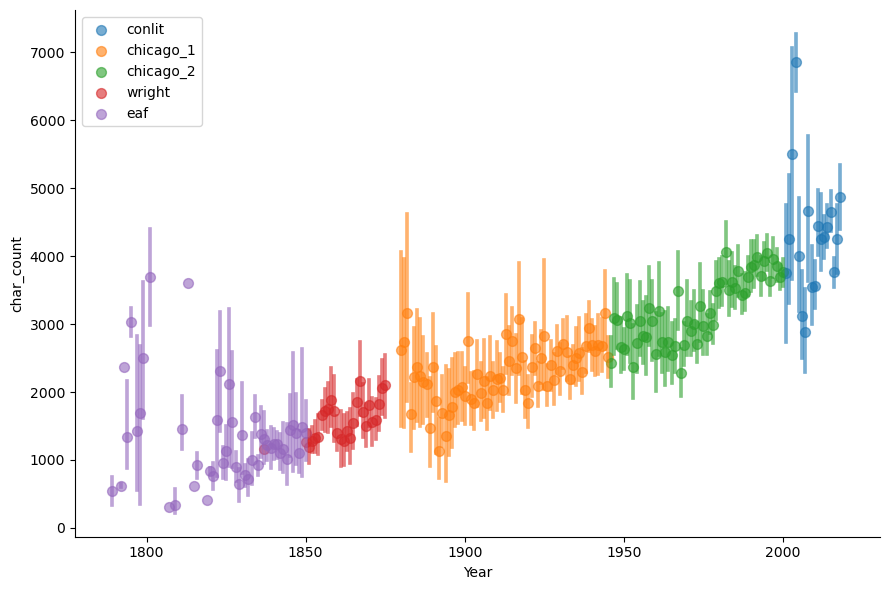

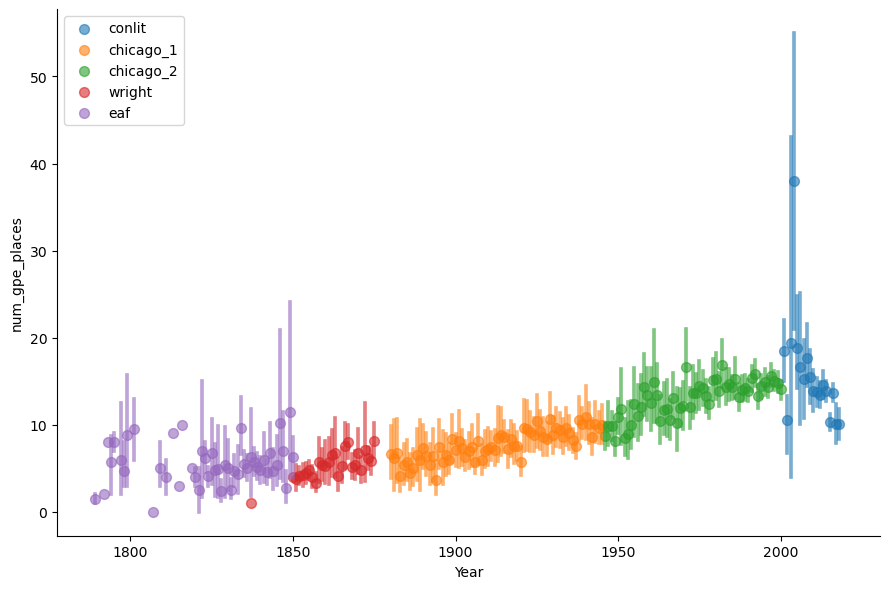

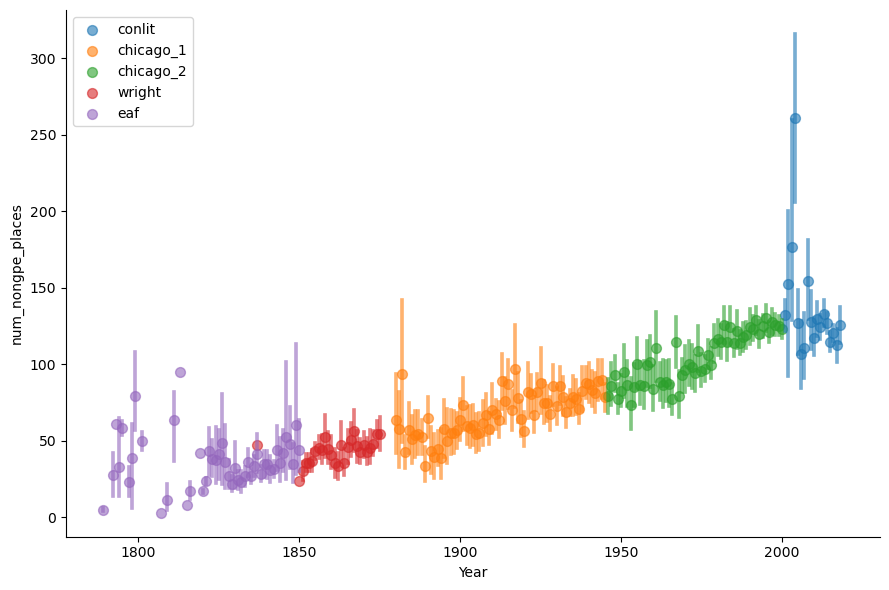

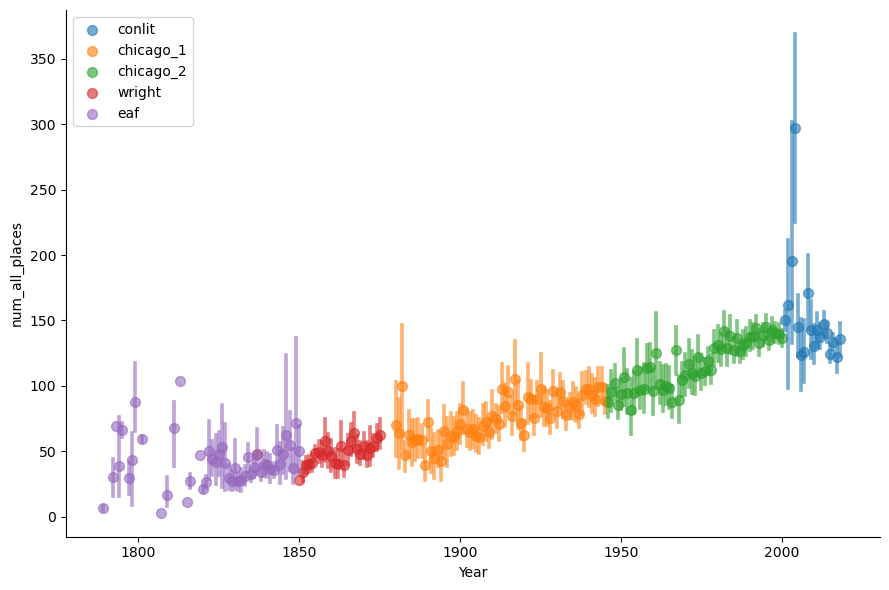

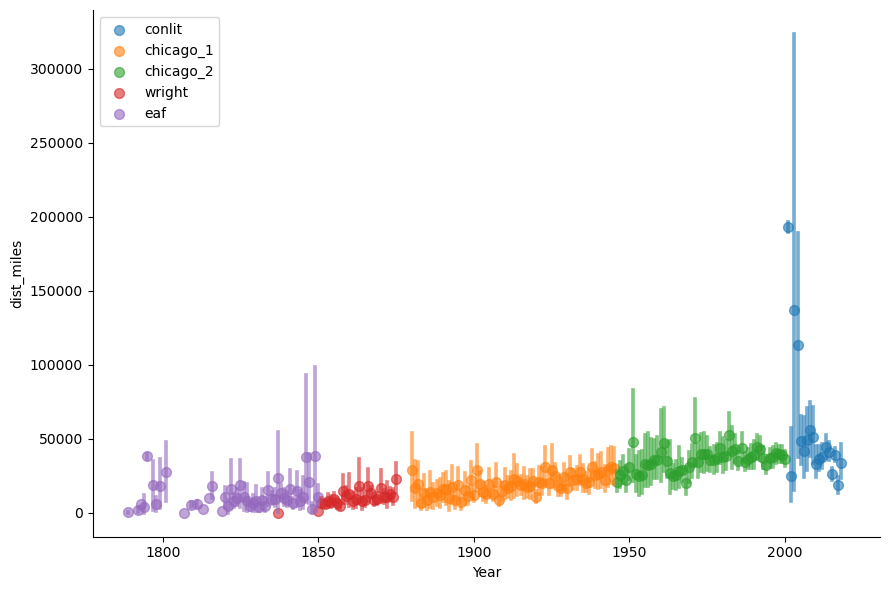

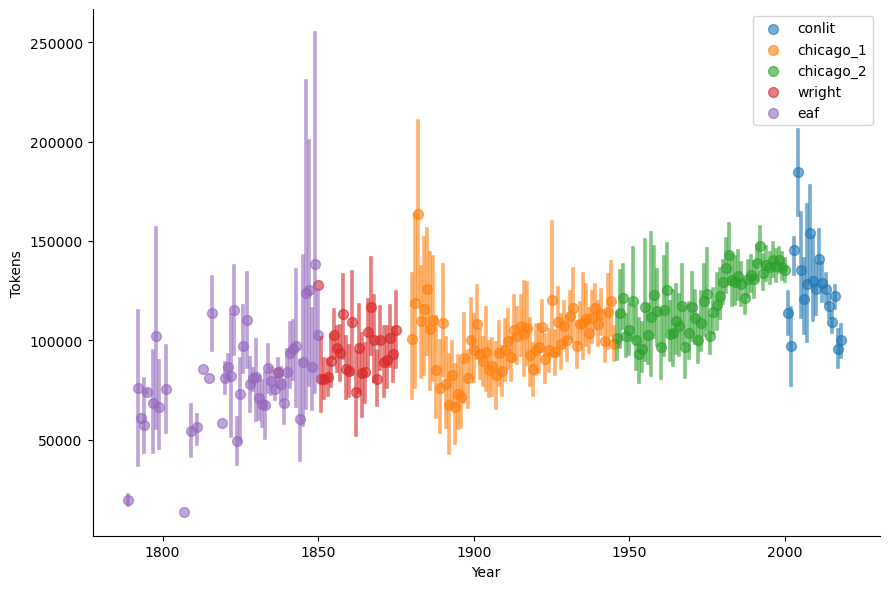

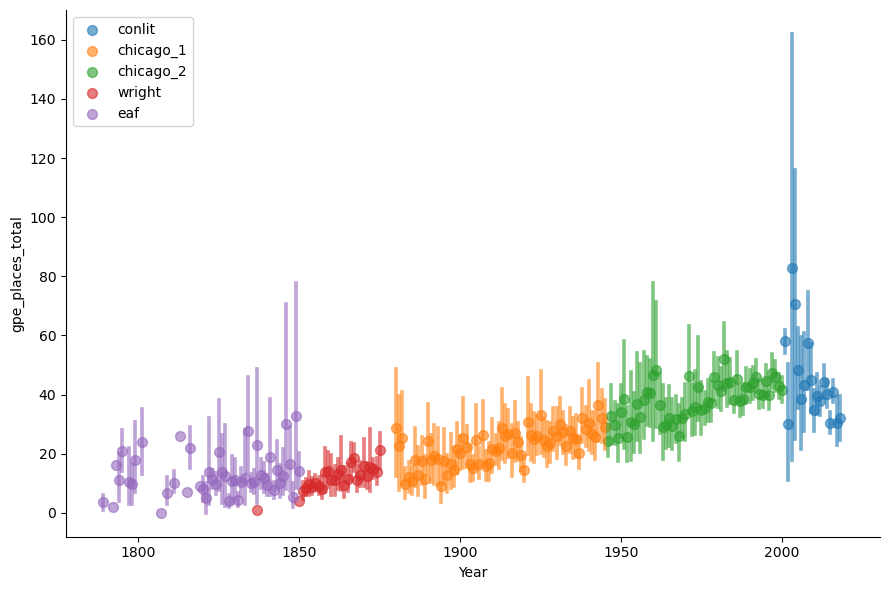

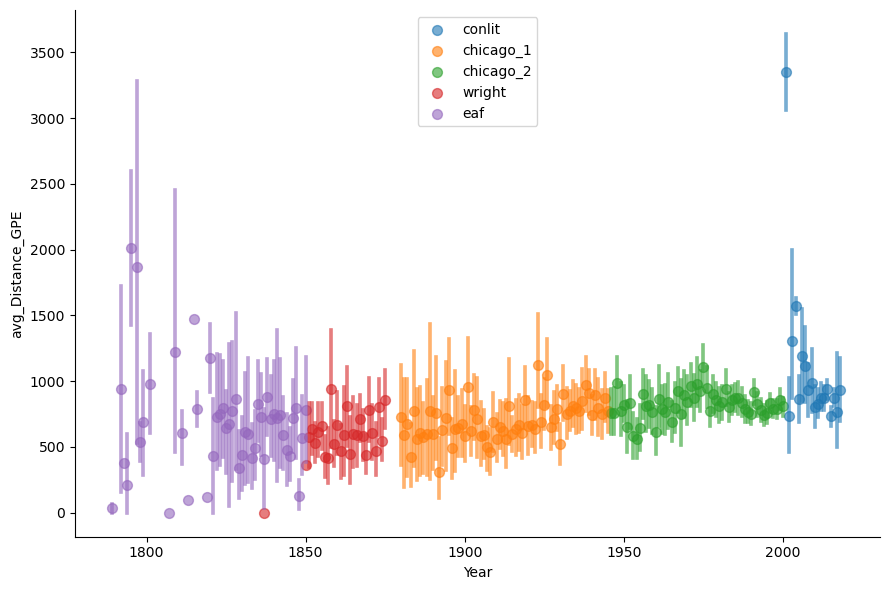

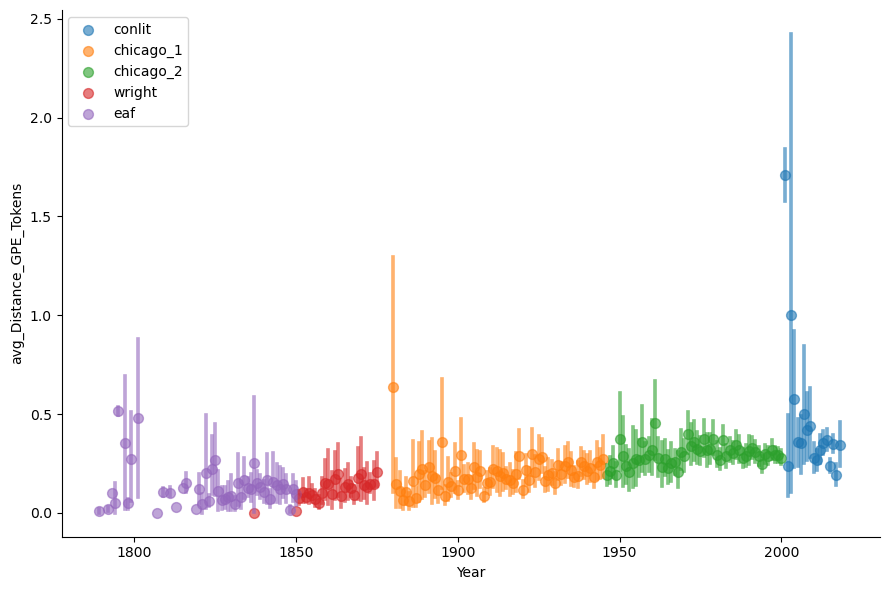

In [10]:
# plot features over time

# restrict to fiction
fic_data = data.loc[data.Category=='FIC']

# use all informative numeric columns
cols_to_drop_from_plot = ['char_id', 'char_rank', 'pub_date']
numeric_cols = fic_data[fic_data.columns[fic_data.notna().all()]].select_dtypes(include='number').drop(columns=cols_to_drop_from_plot).columns

# create plots
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = np.arange(fic_data.pub_date.min(), fic_data.pub_date.max(), 1)
    for col in numeric_cols:
        sns.lmplot(
            x='pub_date', 
            y=col, 
            data=fic_data, 
            #y_partial='Category', # control for fiction/nonfiction
            fit_reg=False,
            x_bins=bins, #fixed total bins by year
            #x_bins=10, # number of bins per source
            hue='source',
            legend=False,
            height=6,
            aspect=1.5,
            scatter_kws={'alpha':0.6}
        )
        plt.xlabel('Year')
        plt.ylabel(col)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

### Outliers

In [11]:
# highest avg distance per GPE
outliers = fic_data[['dist_miles', 'avg_Distance_GPE', 'avg_Distance_GPE_Tokens', 'source']].sort_values(by='avg_Distance_GPE', ascending=False).head(20).join(meta)
outliers

,dist_miles,avg_Distance_GPE,avg_Distance_GPE_Tokens,source,author,title,pub_date,author_gender
book_id,,,,,,,,
"2017_Thompson,Lisa_TheGoldfishBoy_MG",21289.717821,7096.572607,0.244791,conlit,"Thompson, Lisa",TheGoldfishBoy,2017,F
00011895,11918.674966,5959.337483,0.159020,chicago_2,"Taylor, Elizabeth",A wreath of roses,1949,F
00024828,29469.942611,5893.988522,0.243934,chicago_2,"Budnitz, Judy",If I told you once,1999,F
00011347,57803.253892,5254.841263,0.694509,chicago_1,"Wallace, Edgar",The just men of Cordova,1931,M
00010885,14324.979879,4774.993293,0.102408,chicago_2,"Buck, Pearl S.",Peony,1948,F
00003752,75469.987858,4716.874241,0.651761,chicago_1,"MacGrath, Harold",The adventures of Kathlyn,1914,M
00011526,9401.638640,4700.819320,0.079798,chicago_1,"Stewart, Alfred Walter",A minor operation,1937,M
00010452,37583.890361,4697.986295,0.403499,chicago_1,"Queen, Ellery",The Chinese orange mystery,1934,NaN
"2018_Mass,Wendy_Bob_MG",66670.430300,4444.695353,1.799229,conlit,"Mass, Wendy",Bob,2018,F


In [12]:
# high distance per GPE in CONLIT
print("CONLIT")
for item in conlit.loc[outliers.loc[outliers.source=='conlit'].index, 'gpe_sequences']:
    print(item)
    
print("\nEARLY")
for item in early.loc[outliers.loc[outliers.source!='conlit'].index, 'gpe_sequences']:
    print(item)

CONLIT
['New York', 'New Zealand', 'Spain']
['Australia', 'Egypt', 'Massachusetts', 'Australia', 'the United States', 'Yarn', 'Philippa', 'Istanbul', 'Singapore', 'Istanbul', 'Singapore', 'Finland', 'Tokyo']
['Brighton', 'China', 'Bergerac', 'Glen', 'Belmarsh', 'Glen', 'Belmarsh']

EARLY
['Middlemarch', 'Bournemouth']
['Baba', 'Europe', 'Miami', 'Sidney', 'Lisbon']
['England', 'Australia', 'Spain', 'Serrington Gardens', 'England', 'Australia', 'Cheapside', 'London', 'Australia', 'England']
['Palestine', 'Kung', 'Peking']
['India', 'Allaha', 'Singapore', 'Ceylon', 'Hindustani', 'India', 'Hawaii', 'Allaha', 'Pundita', 'Allaha', 'Hind', 'India']
['Ravensthorpe', 'Glasgow']
['China', 'Bashan', 'New York', 'China', 'Chicago', 'China', 'Chicago']
['Massachusetts', 'Zanzibar', 'New England', 'Zanzibar', 'Stanley', 'Livingstone', 'Zanzibar', 'Waltham', 'Massachusetts', 'Zanzibar', 'Massachusetts', 'Zanzibar', 'New England', 'Zanzibar', 'Stanley', 'Livingstone', 'Zanzibar', 'Waltham', 'Massachu

Yeah, so these make sense. They're books with generally few GPEs that are widely separated.